### Bayesian inference of concentration from dilution series

The linear model that this notebook is based on is the Beer-Lambert law from chemistry. 
It says that the spectral absorption of a solution can be written in terms of the molar extinction coefficient, $\epsilon_i$. Simply,

$$
A = l\epsilon c,
$$

where A is the absoprtion of a solution of molar concentration, $c$ with molar extinction coefficient $\epsilon$ over a path length $l$.
The goal is go use this relationship to determine the concentration of a sample with a known extinction coefficient. 
This can be achieved by creating a dilution series of the sample and measuring the absorbance for each dilution. 
The dilution factor of a given sample is
$$
D = \frac {V_S + V_P} {V_P}
$$
Where $V_S$ is the volume of solvent into which $V_P$ of the original protein sample has been dissolved.
Each dilution then constrains the estimated concentration of the original sample. 
$$
\hat A_i = \frac {l\epsilon \hat c} {D_i}
$$

This notebook models the observed data as
$$\begin{align}
\hat c &\sim \mathcal{N} (100, 50)\\
df &\sim HalfNormal(10) \\
A^{obs}_i &\sim StudentT(df, loc = \hat A_i, scale=fractional\_prior\_error \cdot \hat A_i).
\end{align}$$
The measurement_error should be a credible estimate for the accuracy of your instrument's absorbance measurement error. 


In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

Populating the interactive namespace from numpy and matplotlib


# Enter the data
X = dilution factor
Y = nanodrop absorbance reading


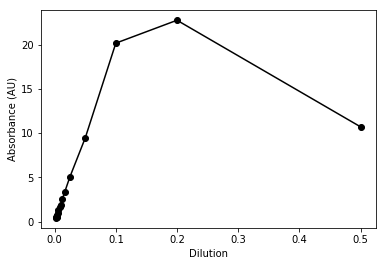

In [63]:
#here are the coefficients for eGFP @ 488 nm
epsilon = 56000. #extinction (per Molar per cm)
mw = 26941.48  #molecular weight (g/mol)


#Dilution factor
D = 1./np.array([
    2,
    5,
    10,
    20,
    40,
    60,
    80,
    100,
    120,
    160,
    200,
    240,
    260,
    300,
    320,
    360,
    400
])

Y = np.array([
    10.71,
    22.76,
    20.17,
    9.45,
    5.06,
    3.38,
    2.54,
    1.92,
    1.68,
    1.28,
    .93,
    .79,
    .68,
    .52,
    .52,
    .56,
    .41
])



plt.plot(D, Y,'ko-')
plt.xlabel('Dilution')
plt.ylabel('Absorbance (AU)')
plt.show()



In [64]:
#fractional error of nanodrop
nanodrop_error_scale = 0.05

def regression(D):
    df = ed.HalfNormal(10, name='df')
    Chat = ed.Normal(100, 50., name='Chat')
    Ahat = epsilon*Chat*D/mw
    predictions = ed.StudentT(
        df,
        Ahat,
        nanodrop_error_scale*Ahat,
        name="predictions"
    )
    return predictions

log_joint = ed.make_log_joint_fn(regression)

def target_log_prob_fn(Chat, df):
  return log_joint(
      D=D,
      df = df,
      Chat=Chat,
      predictions=Y,
  )

num_results = int(10e3)
n_burnin = int(5e3)
step_size = 0.1
num_leapfrog_steps = 10

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps,
)

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state = [
        100.,
        4.,
    ]
)

with tf.Session() as sess:
    [
        states_,
        is_accepted,
    ] = sess.run([
        states, 
        kernel_results.is_accepted
    ])

samples = [i[n_burnin:] for i in states_]
accepted_samples = is_accepted[n_burnin:]
print('Acceptance rate: {:0.1f}'.format(100*np.mean(accepted_samples)))



Acceptance rate: 99.5



Posterior sample concentration distribution (mg/ml)
      mean: 93.84
    median: 93.89
   95 % CI: (90.15 , 97.39)


Posterior degrees of freedom
      mean: 1.27
    median: 1.20
   95 % CI: (0.57 , 97.39)



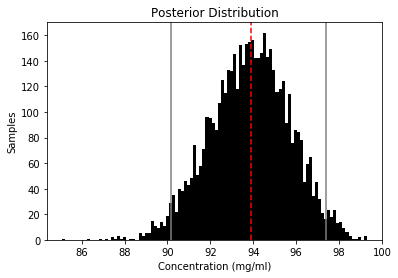

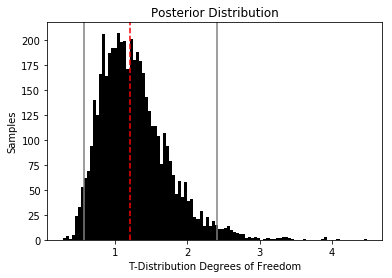

In [89]:
plt.figure()
_ = hist(samples[0], 100, color='k')
plt.axvline(np.median(samples[0]), linestyle='--', color='r')
plt.axvline(np.percentile(samples[0], 2.5), color='grey')
plt.axvline(np.percentile(samples[0], 97.5), color='grey')
plt.title("Posterior Distribution")
plt.xlabel("Concentration (mg/ml)")
plt.ylabel("Samples")

plt.figure()
_ = hist(samples[1], 100, color='k')
plt.axvline(np.median(samples[1]), linestyle='--', color='r')
plt.axvline(np.percentile(samples[1], 2.5), color='grey')
plt.axvline(np.percentile(samples[1], 97.5), color='grey')
plt.title("Posterior Distribution")
plt.xlabel("T-Distribution Degrees of Freedom")
plt.ylabel("Samples")


message = f"""
Posterior sample concentration distribution (mg/ml)
      mean: {np.mean(samples[0]):0.2f}
    median: {np.median(samples[0]):0.2f}
   95 % CI: ({np.percentile(samples[0], 2.5):0.2f} , {np.percentile(samples[0], 97.5):0.2f})
"""
print(message)

message = f"""
Posterior degrees of freedom
      mean: {np.mean(samples[1]):0.2f}
    median: {np.median(samples[1]):0.2f}
   95 % CI: ({np.percentile(samples[1], 2.5):0.2f} , {np.percentile(samples[0], 97.5):0.2f})
"""
print(message)